# Описание проекта

Оператор связи хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

### Данные

[final_provider.zip](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/ac39c23b-718e-4cd6-bdaa-85b3a127a457/final_provider.zip)

Данные также находятся в папке `/datasets/final_provider/`

## Задачи проекта

- построить модель с максимальным значением `AUC-ROC`
- проверить `AUC-ROC` на тестовой выборке
- в качестве дополнительной метрики максимизировать `accuracy`

# <font color="blue"> Шаг 1. Подключение библиотек,  загрузка данных и анализ общей информации

In [1]:
# Подключаем необходимые библиотеки

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings

warnings.filterwarnings('ignore')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

In [2]:
# Cоздание функции общей информации о датасете

def info(df):
    print('INFO')
    display(df.info())
    print('HEAD 10')
    display(df.head(10))
    print('DESCRIBE')
    display(df.describe())
    print('SPACES')
    display(df.isnull().sum())
    # Проверка на дублирующиеся индексы,
    # (так как в целом признаки могут быть полностью идентичными у разных пользователей)
    print('DUPLICATES (по индексу)')
    display(df.index[df.index.duplicated()].unique())

## 1.1.  Анализ датасета contract.csv (информация о договоре)

In [3]:
contract_df = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')

In [4]:
info(contract_df)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


None

HEAD 10


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05


DESCRIBE


,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


SPACES


BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

## 1.1. Анализ датасета contract.csv (информация о договоре). Вывод.

- в датасете 7 043 записи, представленные 7-мью признаками
- наименования столбцов информативны и удобочитаемы
- пропуски и дубликаты отстутствуют
- для дальнейшей работы необходимо произвести замену типов данных ряда признаков

## 1.2.  Анализ датасета personal.csv (персональные данные клиента)

In [5]:
personal_df = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')

In [6]:
info(personal_df)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(3)
memory usage: 275.1+ KB


None

HEAD 10


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


DESCRIBE


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


SPACES


gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

## 1.2. Анализ датасета personal.csv (персональные данные клиента). Вывод.

- в датасете 7 043 записи, представленные 4-мя признаками
- наименования столбцов информативны и удобочитаемы
- пропуски и дубликаты отстутствуют
- для дальнейшей работы необходимо произвести замену строковых типов данных на категориальные

## 1.3.  Анализ датасета internet.csv (информация о интернет-услугах)

In [7]:
internet_df = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')

In [8]:
info(internet_df)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(7)
memory usage: 344.8+ KB


None

HEAD 10


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


DESCRIBE


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


SPACES


InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

## 1.3.  Анализ датасета internet.csv (информация о интернет-услугах). Вывод.

- в датасете 5 517 записей, представленные 4-мя признаками
- наименования столбцов информативны и удобочитаемы
- пропуски и дубликаты отстутствуют
- для дальнейшей работы необходимо произвести замену строковых типов данных на категориальные

## 1.4.  Анализ датасета phone.csv (информация о услугах телефонии)

In [9]:
phone_df = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID')

In [10]:
info(phone_df)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
MultipleLines    6361 non-null object
dtypes: object(1)
memory usage: 99.4+ KB


None

HEAD 10


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


DESCRIBE


,MultipleLines
count,6361
unique,2
top,No
freq,3390


SPACES


MultipleLines    0
dtype: int64

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

## 1.4.  Анализ датасета phone.csv (информация о услугах телефонии). Вывод.

- в датасете 6 361 запись, представленные 1-ним признаком
- наименования столбца информативно и удобочитаемо
- пропуски и дубликаты отстутствуют
- для дальнейшей работы необходимо произвести замену строкового типа данных на категориальный

#Шаг 1. Подключение библиотек, загрузка данных и анализ общей информации. Выводы.

- исходные данные представлены 4-мя датасетами, следующей размерности:
    - датасет `contract.csv` (информация о договоре): 7 043 запись, 7 признаков
    - датасет `personal.csv` (персональные данные клиента): 7 043 запись, 4 признака
    - датасет `internet.csv` (информация о интернет-услугах): 5 517 запись, 4 признака
    - датасет `phone.csv` (информация о услугах телефонии): 6 261 запись, 1 признак
- наименования столбцов соответствуют содержимому, удобочитаемы и информативны
- учитывая, что значения признаков могут полностью совпадать у разных клиентов, проверка на дубликаты проведена по значению индекса (`customerID`). Дубликаты не обнаружены.
- пропущенных значений не обнаружено
- для дальнейшей корректной обработки данных необходимо произвести замену типов данных ряда признаков

# <font color="blue"> Шаг 2. Преобразование данных

## 2.1. Датасет contract.csv (информация о договоре)

### 2.1.1. Замена типов данных

In [11]:
print('INFO')
display(contract_df.info())
print('HEAD 10')
display(contract_df.head(10))

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
BeginDate           7043 non-null object
EndDate             7043 non-null object
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
dtypes: float64(1), object(6)
memory usage: 760.2+ KB


None

HEAD 10


,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05


Произведем замену строковых типов данных ряда признаков на типы необходимые для дальнейшей работы. Также принимаем во внимание , что признаки `BeginDate` и `EndDate` сами по себе никак не персонализируют клиента, а значит их "чистое" использование в модели(-ях) избыточно. Создадим, на их основе, два более "полезных", с точки зрения персонализации, новых признака: `ContractStatus` (статус контракта, 1 - если контракт действует и 0 - если контракт завершен) и `ContractDuration` (длительность контракта, в днях).

In [12]:
# преобразуем строковые данные признака BeginDate в тип "datetime"
contract_df['BeginDate'] = pd.to_datetime(contract_df["BeginDate"], format='%Y-%m-%d')
# создаем новый булевый признак ContractStatus
contract_df['ContractStatus'] = contract_df['EndDate'].apply(lambda x: 1 if x == "No" else 0)
# в признаке EndDate меняем значение "No" на "2020-02-01"
contract_df['EndDate'] = contract_df['EndDate'].apply(lambda x: '2020-02-01' if x == "No" else x)
# преобразуем строковые данные признака EndDate в тип "datetime"
contract_df['EndDate'] = pd.to_datetime(contract_df["EndDate"], format='%Y-%m-%d')
# создаем новый признак ContractDuration
contract_df['ContractDuration'] = (contract_df['EndDate'] - contract_df['BeginDate']).dt.days
# удаляем из датасета признаки BeginDate и EndDate
contract_df= contract_df.drop(['BeginDate', 'EndDate'], axis=1)
# признак TotalCharges преобразуем из строкового типа в "float", при этом значения " " заменяем на "0"
contract_df['TotalCharges'] = contract_df['TotalCharges'].apply(lambda x: '0' if x == " " else x)
contract_df['TotalCharges'] = pd.to_numeric(contract_df['TotalCharges'])

Проверка результата

In [13]:
info(contract_df)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
ContractStatus      7043 non-null int64
ContractDuration    7043 non-null int64
dtypes: float64(2), int64(2), object(3)
memory usage: 760.2+ KB


None

HEAD 10


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractStatus,ContractDuration
customerID,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,1,31
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,1,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,0,61
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,1,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,0,61
9305-CDSKC,Month-to-month,Yes,Electronic check,99.65,820.50,0,245
1452-KIOVK,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,1,671
6713-OKOMC,Month-to-month,No,Mailed check,29.75,301.90,1,306
7892-POOKP,Month-to-month,Yes,Electronic check,104.80,3046.05,0,853


DESCRIBE


,MonthlyCharges,TotalCharges,ContractStatus,ContractDuration
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.734630,985.996166
std,30.090047,2266.794470,0.441561,747.587844
min,18.250000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000
50%,70.350000,1394.550000,1.000000,883.000000
75%,89.850000,3786.600000,1.000000,1676.000000
max,118.750000,8684.800000,1.000000,2191.000000


SPACES


Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
ContractStatus      0
ContractDuration    0
dtype: int64

DUPLICATES (по индексу)


Index([], dtype='object', name='customerID')

### 2.1.2. Проверка на уникальность строковых признаков

In [14]:
print("Уникальные значения признака Type:", contract_df['Type'].unique())
print("Уникальные значения признака PaperlessBilling:", contract_df['PaperlessBilling'].unique())
print("Уникальные значения признака PaymentMethod:", contract_df['PaymentMethod'].unique())

Уникальные значения признака Type: ['Month-to-month' 'One year' 'Two year']
Уникальные значения признака PaperlessBilling: ['Yes' 'No']
Уникальные значения признака PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


## 2.1. Датасет contract.csv (информация о договоре). Вывод.

- произведена замена типов данных, со строкового на "datetime", признаков `BeginDate` и `EndDate`, с целью получения двух новых признаков: `ContractStatus` (статус контракта) и `ContractDuration` (длительность контракта, в днях)
- изначальные признаки `BeginDate` и `EndDate` удалены в связи с их "безполезностью" для дальнейшей работы 
- произведена замена типов данных, со строкового на "float", признака `TotalCharges`
- значения строковых признаков `Type`, `PaperlessBilling` и `PaymentMethod` уникальны и удовлятворяют условиям дальнейшей обработки

## 2.2. Датасет personal.csv (персональные данные клиента)

### 2.2.1. Замена типов данных

In [15]:
print('INFO')
display(personal_df.info())
print('HEAD 10')
display(personal_df.head(10))

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
gender           7043 non-null object
SeniorCitizen    7043 non-null int64
Partner          7043 non-null object
Dependents       7043 non-null object
dtypes: int64(1), object(3)
memory usage: 595.1+ KB


None

HEAD 10


,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No
9305-CDSKC,Female,0,No,No
1452-KIOVK,Male,0,No,Yes
6713-OKOMC,Female,0,No,No
7892-POOKP,Female,0,Yes,No


Типы данных признаков соответствуют содержанию и пригодны для дальнейшей работы. Оставляем все как есть.

### 2.2.2. Проверка на уникальность строковых признаков

In [16]:
print("Уникальные значения признака gender:", personal_df['gender'].unique())
print("Уникальные значения признака Partner:", personal_df['Partner'].unique())
print("Уникальные значения признака Dependents:", personal_df['Dependents'].unique())

Уникальные значения признака gender: ['Female' 'Male']
Уникальные значения признака Partner: ['Yes' 'No']
Уникальные значения признака Dependents: ['No' 'Yes']


## 2.2. Датасет personal.csv (персональные данные клиента). Вывод.

- типы данных признаков соответствуют содержанию и пригодны для дальнейшей работы
- значения строковых признаков `gender`, `Partner` и `Dependents` уникальны и удовлятворяют условиям дальнейшей обработки

## 2.3. Датасет internet.csv (информация о интернет-услугах)

### 2.3.1. Замена типов данных

In [17]:
print('INFO')
display(internet_df.info())
print('HEAD 10')
display(internet_df.head(10))

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
dtypes: object(7)
memory usage: 504.8+ KB


None

HEAD 10


,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No
9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
6713-OKOMC,DSL,Yes,No,No,No,No,No
7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes


Типы данных признаков соответствуют содержанию и пригодны для дальнейшей работы. Оставляем все как есть.

### 2.3.2. Проверка на уникальность строковых признаков

In [18]:
print("Уникальные значения признака InternetService:", internet_df['InternetService'].unique())
print("Уникальные значения признака OnlineSecurity:", internet_df['OnlineSecurity'].unique())
print("Уникальные значения признака OnlineBackup:", internet_df['OnlineBackup'].unique())
print("Уникальные значения признака DeviceProtection:", internet_df['DeviceProtection'].unique())
print("Уникальные значения признака TechSupport:", internet_df['TechSupport'].unique())
print("Уникальные значения признака StreamingTV:", internet_df['StreamingTV'].unique())
print("Уникальные значения признака StreamingMovies:", internet_df['StreamingMovies'].unique())

Уникальные значения признака InternetService: ['DSL' 'Fiber optic']
Уникальные значения признака OnlineSecurity: ['No' 'Yes']
Уникальные значения признака OnlineBackup: ['Yes' 'No']
Уникальные значения признака DeviceProtection: ['No' 'Yes']
Уникальные значения признака TechSupport: ['No' 'Yes']
Уникальные значения признака StreamingTV: ['No' 'Yes']
Уникальные значения признака StreamingMovies: ['No' 'Yes']


## 2.3. Датасет internet.csv (информация о интернет-услугах). Вывод.

- типы данных признаков соответствуют содержанию и пригодны для дальнейшей работы
- значения строковых признаков `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` и `StreamingMovies` уникальны и удовлятворяют условиям дальнейшей обработки

## 2.4. Датасет phone.csv (информация о услугах телефонии)

### 2.4.1. Замена типов данных

In [19]:
print('INFO')
display(phone_df.info())
print('HEAD 10')
display(phone_df.head(10))

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
MultipleLines    6361 non-null object
dtypes: object(1)
memory usage: 419.4+ KB


None

HEAD 10


,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes
7892-POOKP,Yes
6388-TABGU,No
9763-GRSKD,No
7469-LKBCI,No


Тип данных признака соответствует содержанию и пригоден для дальнейшей работы. Оставляем все как есть.

### 2.4.2. Проверка на уникальность строковых признаков

In [20]:
print("Уникальные значения признака MultipleLines:", phone_df['MultipleLines'].unique())

Уникальные значения признака MultipleLines: ['No' 'Yes']


## 2.4. Датасет phone.csv (информация о услугах телефонии). Вывод.

- типы данных признака соответствует содержанию и пригоден для дальнейшей работы
- значения строкового признака `MultipleLines` уникальны и удовлятворяют условиям дальнейшей обработки

# Шаг 2. Преобразование данных. Выводы.

В рамках процесса преобразования данных осуществлено следующее:
    
- датасет `contract.csv`:
    - произведена замена типов данных, со строкового на "datetime", признаков `BeginDate` и `EndDate`, с целью получения двух новых признаков: `ContractStatus` (статус контракта) и `ContractDuration` (длительность контракта, в днях)
    - изначальные признаки `BeginDate` и `EndDate` удалены в связи с их "безполезностью" для дальнейшей работы 
    - произведена замена типов данных, со строкового на "float", признака `TotalCharges`
    - проведена проверка уникальности значений строковых признаков. Значения признаков уникальны и стандартизированы, что удовлетворяет условиям последующей работы с данными
    
- датасет `personal.csv`:
    - типы данных признаков оставлены без изменений, как соответствующие условиям дальнейшей обработки
    - проведена проверка уникальности значений строковых признаков. Значения признаков уникальны и стандартизированы, что удовлетворяет условиям последующей работы с данными
    
- датасет `internet.csv`:
    - типы данных признаков оставлены без изменений, как соответствующие условиям дальнейшей обработки
    - проведена проверка уникальности значений строковых признаков. Значения признаков уникальны и стандартизированы, что удовлетворяет условиям последующей работы с данными
    
- датасет `phone.csv`:
    - тип данных признака оставлен без изменений, как соответствующий условиям дальнейшей обработки
    - проведена проверка уникальности значений строкового признака. Значения признака уникальны и стандартизированы, что удовлетворяет условиям последующей работы с данными
    
- пропуски и дубликаты отсутствуют, во всех 4-х датасетах

# <font color="blue"> Шаг 3. Создание общего датасета

## 3.1. Объединение датасетов

In [21]:
df=pd.concat([contract_df, personal_df, internet_df,phone_df], axis=1)

Проверяем результат

In [22]:
info(df)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 19 columns):
Type                7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null float64
ContractStatus      7043 non-null int64
ContractDuration    7043 non-null int64
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
InternetService     5517 non-null object
OnlineSecurity      5517 non-null object
OnlineBackup        5517 non-null object
DeviceProtection    5517 non-null object
TechSupport         5517 non-null object
StreamingTV         5517 non-null object
StreamingMovies     5517 non-null object
MultipleLines       6361 non-null object
dtypes: float64(2), int64(3), object(14)
memory usage: 1.1+ MB


None

HEAD 10


,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,ContractStatus,ContractDuration,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0002-ORFBO,One year,Yes,Mailed check,65.60,593.30,1,276,Female,0,Yes,Yes,DSL,No,Yes,No,Yes,Yes,No,No
0003-MKNFE,Month-to-month,No,Mailed check,59.90,542.40,1,276,Male,0,No,No,DSL,No,No,No,No,No,Yes,Yes
0004-TLHLJ,Month-to-month,Yes,Electronic check,73.90,280.85,0,122,Male,0,No,No,Fiber optic,No,No,Yes,No,No,No,No
0011-IGKFF,Month-to-month,Yes,Electronic check,98.00,1237.85,0,396,Male,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No
0013-EXCHZ,Month-to-month,Yes,Mailed check,83.90,267.40,0,91,Female,1,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,No
0013-MHZWF,Month-to-month,Yes,Credit card (automatic),69.40,571.45,1,276,Female,0,No,Yes,DSL,No,No,No,Yes,Yes,Yes,No
0013-SMEOE,Two year,Yes,Bank transfer (automatic),109.70,7904.25,1,2163,Female,1,Yes,No,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,No
0014-BMAQU,Two year,Yes,Credit card (automatic),84.65,5377.80,1,1918,Male,0,Yes,No,Fiber optic,Yes,No,No,Yes,No,No,Yes
0015-UOCOJ,Month-to-month,Yes,Electronic check,48.20,340.35,1,215,Female,1,No,No,DSL,Yes,No,No,No,No,No,No
0016-QLJIS,Two year,Yes,Mailed check,90.45,5957.90,1,1979,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Yes


DESCRIBE


,MonthlyCharges,TotalCharges,ContractStatus,ContractDuration,SeniorCitizen
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.734630,985.996166,0.162147
std,30.090047,2266.794470,0.441561,747.587844,0.368612
min,18.250000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000
50%,70.350000,1394.550000,1.000000,883.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000


SPACES


Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
ContractStatus         0
ContractDuration       0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
MultipleLines        682
dtype: int64

DUPLICATES (по индексу)


Index([], dtype='object')

## 3.1. Объединение датасетов. Вывод.

В результате объединения датасетов, обнаружены следующие проблемы:

- внушительное количество пропусков (1 526, или около 21,6% от генеральной совокупности) в признаках: `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`. Разумным объяснением, в связи с невозможностью получения дополнительной информации, будет то, что вышеперечисленные услуги являются дополнительными и не всегда используются клиентами. Просто удалить такие записи нежелательно, в силу их значительного количества. Поэтому в дальнейшем заменим эти пропуски значением "No data"
- 682 пропуска в признаке `MultipleLines`. Скорее всего их природа аналогична вышеуказанной причине. Также заменим эти пропуски значением "No data"
- в объединенном датасете много категориальных признаков. Необходимо провести их преобразование, приведя к численным значениям

## 3.2. Работа с пропусками

In [23]:
df=df.fillna('No data')

Проверяем результат

In [24]:
print('SPACES')
display(df.isnull().sum())

SPACES


Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
ContractStatus      0
ContractDuration    0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

## 3.2. Работа с пропусками. Вывод.

В результате замены пропущенных значений единым значением "No data", пропуски в объединенном датасете отсутствуют.

## 3.3. Преобразование категориальных признаков в числовые

In [25]:
data = df.copy(deep=True)
data = pd.get_dummies(data, drop_first=True)

Проверяем результат

In [26]:
info(data)

INFO
<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 0002-ORFBO to 9995-HOTOH
Data columns (total 30 columns):
MonthlyCharges                           7043 non-null float64
TotalCharges                             7043 non-null float64
ContractStatus                           7043 non-null int64
ContractDuration                         7043 non-null int64
SeniorCitizen                            7043 non-null int64
Type_One year                            7043 non-null uint8
Type_Two year                            7043 non-null uint8
PaperlessBilling_Yes                     7043 non-null uint8
PaymentMethod_Credit card (automatic)    7043 non-null uint8
PaymentMethod_Electronic check           7043 non-null uint8
PaymentMethod_Mailed check               7043 non-null uint8
gender_Male                              7043 non-null uint8
Partner_Yes                              7043 non-null uint8
Dependents_Yes                           7043 non-null uint8
InternetService_Fibe

None

HEAD 10


,MonthlyCharges,TotalCharges,ContractStatus,ContractDuration,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,DeviceProtection_No data,DeviceProtection_Yes,TechSupport_No data,TechSupport_Yes,StreamingTV_No data,StreamingTV_Yes,StreamingMovies_No data,StreamingMovies_Yes,MultipleLines_No data,MultipleLines_Yes
0002-ORFBO,65.60,593.30,1,276,0,1,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
0003-MKNFE,59.90,542.40,1,276,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
0004-TLHLJ,73.90,280.85,0,122,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
0011-IGKFF,98.00,1237.85,0,396,1,0,0,1,0,1,...,0,1,0,0,0,1,0,1,0,0
0013-EXCHZ,83.90,267.40,0,91,1,0,0,1,0,0,...,0,0,0,1,0,1,0,0,0,0
0013-MHZWF,69.40,571.45,1,276,0,0,0,1,1,0,...,0,0,0,1,0,1,0,1,0,0
0013-SMEOE,109.70,7904.25,1,2163,1,0,1,1,0,0,...,0,1,0,1,0,1,0,1,0,0
0014-BMAQU,84.65,5377.80,1,1918,0,0,1,1,1,0,...,0,0,0,1,0,0,0,0,0,1
0015-UOCOJ,48.20,340.35,1,215,1,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
0016-QLJIS,90.45,5957.90,1,1979,0,0,1,1,0,0,...,0,1,0,1,0,1,0,1,0,1


DESCRIBE


,MonthlyCharges,TotalCharges,ContractStatus,ContractDuration,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,...,DeviceProtection_No data,DeviceProtection_Yes,TechSupport_No data,TechSupport_Yes,StreamingTV_No data,StreamingTV_Yes,StreamingMovies_No data,StreamingMovies_Yes,MultipleLines_No data,MultipleLines_Yes
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,...,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,64.761692,2279.734304,0.734630,985.996166,0.162147,0.209144,0.240664,0.592219,0.216101,0.335794,...,0.216669,0.343888,0.216669,0.290217,0.216669,0.384353,0.216669,0.387903,0.096834,0.421837
std,30.090047,2266.794470,0.441561,747.587844,0.368612,0.406726,0.427517,0.491457,0.411613,0.472301,...,0.412004,0.475038,0.412004,0.453895,0.412004,0.486477,0.412004,0.487307,0.295752,0.493888
min,18.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.500000,398.550000,0.000000,273.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,70.350000,1394.550000,1.000000,883.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,89.850000,3786.600000,1.000000,1676.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,118.750000,8684.800000,1.000000,2191.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


SPACES


MonthlyCharges                           0
TotalCharges                             0
ContractStatus                           0
ContractDuration                         0
SeniorCitizen                            0
Type_One year                            0
Type_Two year                            0
PaperlessBilling_Yes                     0
PaymentMethod_Credit card (automatic)    0
PaymentMethod_Electronic check           0
PaymentMethod_Mailed check               0
gender_Male                              0
Partner_Yes                              0
Dependents_Yes                           0
InternetService_Fiber optic              0
InternetService_No data                  0
OnlineSecurity_No data                   0
OnlineSecurity_Yes                       0
OnlineBackup_No data                     0
OnlineBackup_Yes                         0
DeviceProtection_No data                 0
DeviceProtection_Yes                     0
TechSupport_No data                      0
TechSupport

DUPLICATES (по индексу)


Index([], dtype='object')

## 3.3. Преобразование категориальных признаков в числовые. Вывод.

В результате преобразования категориальных признаков в числовые, получен единый датасет размерностью 7 043 х 30

# Шаг 3. Создание общего датасета. Выводы.

- при объединении 4-х датасетов возникли следующие проблемы:
    - образовалось большое количество пропусков (1 526, или около 21,6% от генеральной совокупности) в признаках: `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`.
    - 682 пропуска в признаке `MultipleLines`
    - в связи с невозможностью получения дополнительной информации, было принято во внимание то, что вышеперечисленные услуги являются дополнительными и не всегда используются клиентами. Поэтому пропуски были заменены значением "No data"
    - в объединенном датасете много категориальных признаков. Проведено их преобразование к численным значениям
- в результате получен единый датасет размерностью 7 043 х 30, готовый к дальнейшей работе

# <font color="blue"> Шаг 4. Исследовательский анализ данных

## 4.1. Cоотношение между потеряными клиентами  и актуальными

Выясним соотношение между теми клиентами, кто уже прервал контракт и теми чей контракт все еще актуален

ContractStatus
0    0.26537
1    0.73463
Name: MonthlyCharges, dtype: float64 /n



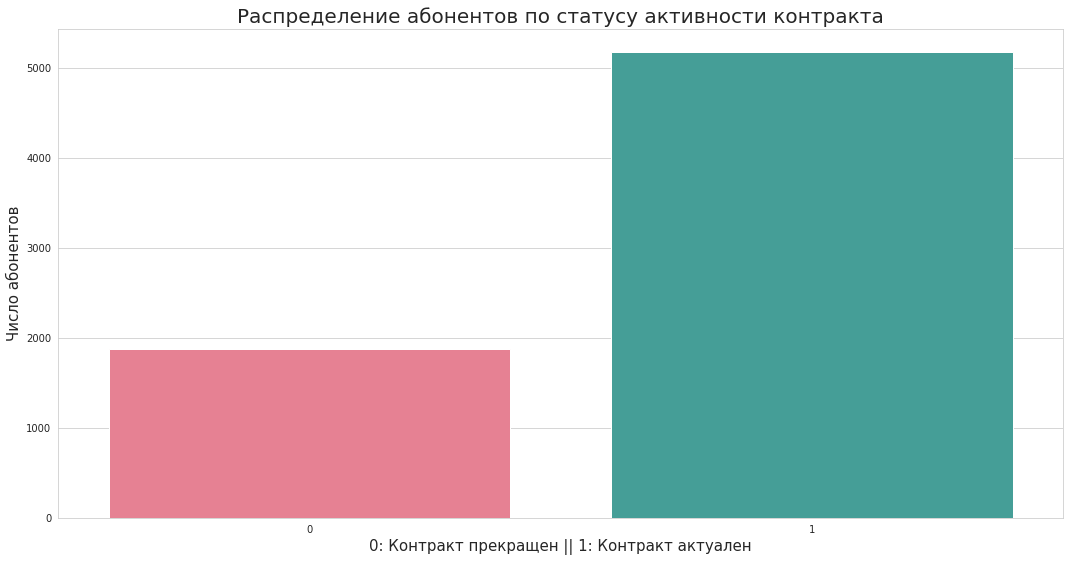

In [27]:
print(data.groupby('ContractStatus')['MonthlyCharges'].count()/ len(data), '/n')
print()
plt.figure(figsize=(18, 9))
with sns.axes_style('whitegrid'):
    sns.countplot(x='ContractStatus', data=data[['ContractStatus']], palette = "husl")
    plt.xlabel('0: Контракт прекращен || 1: Контракт актуален', fontsize = 15)
    plt.ylabel('Число абонентов', fontsize = 15)
    plt.title('Распределение абонентов по статусу активности контракта', fontsize = 20)

## 4.1. Cоотношение между потеряными клиентами и актуальными. Вывод.

- количество клиентов с действующим контрактом составляет около 2/3 от общего числа

## 4.2. Cоотношение между прервавшими контракт клиентами и актуальными клиентами,  в зависимости от типа интернет-соединения (DSL(0) или Оптоволокно(1) )

In [28]:
# Составляем сводную таблицу по количеству абонентов в зависимости от типа соединения
internet_pivot = df.pivot_table(index='InternetService', columns='ContractStatus',
                                values='MonthlyCharges', aggfunc='count').fillna(0).astype('int')/ len(data)
display(internet_pivot)

ContractStatus,0,1
InternetService,,
DSL,0.065171,0.278574
Fiber optic,0.184154,0.255431
No data,0.016044,0.200625


## 4.2. Cоотношение между прервавшими контракт клиентами и актуальными клиентами, в зависимости от типа интернет-соединения (DSL(0) или Оптоволокно(1) ). Вывод.

- наблюдается значительный перевес, по количеству прекращенных контрактов, в группе клиентов подключенных к интернету по оптоволокну. Они более чем в 3 раза чаще разрывали контракт, чем клиенты подключенные по DSL.

## 4.3. Соотношение между прервавшими контракт клиентами и актуальными клиентами, в зависимости от количества линий телефонии (Одна(0) или Несколько(1) )

In [29]:
# Составляем сводную таблицу по количеству абонентов в зависимости от количества линий телефонии
phones_pivot = df.pivot_table(index= 'MultipleLines', columns='ContractStatus',
                              values='MonthlyCharges', aggfunc='count').fillna(0).astype('int')/ len(data)
display(phones_pivot)

ContractStatus,0,1
MultipleLines,,
No,0.120545,0.360784
No data,0.024137,0.072696
Yes,0.120687,0.301150


## 4.3. Соотношение между прервавшими контракт клиентами и актуальными клиентами, в зависимости от количества линий телефонии (Одна(0) или Несколько(1) ). Вывод.

- не обнаружено значимой разницы в количестве прекращенных контрактов между группами клиентов с одной линией телефонии и несколькими (около 12% в обеих группах)

## 4.4. Проверка аномальных выбросов

Проверим численные признаки на предмет аномальных выбросов

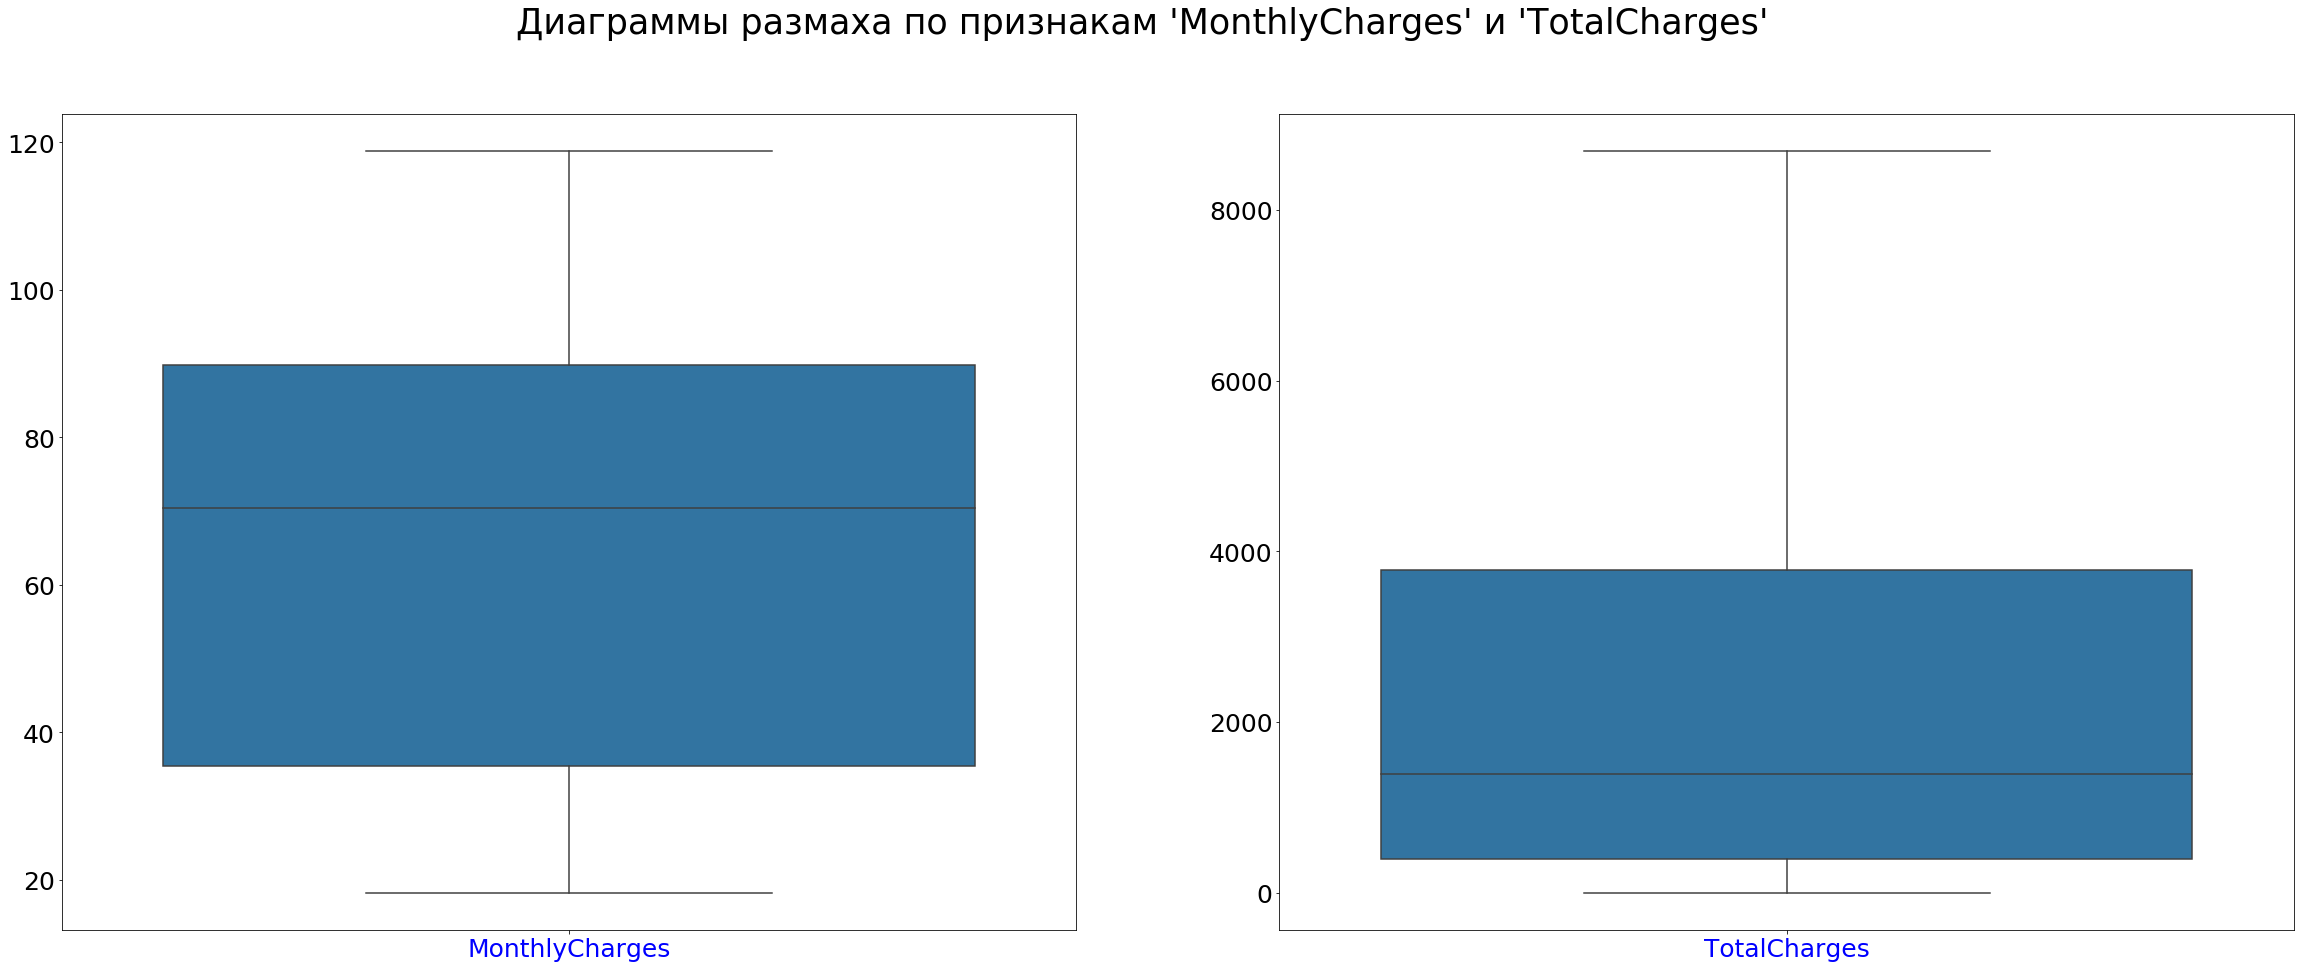

In [30]:
fig, axes = plt.subplots(1, 2, figsize=(40,15))
fig.suptitle("Диаграммы размаха по признакам 'MonthlyCharges' и 'TotalCharges'", fontsize = 35)

sns.boxplot(data=data[['MonthlyCharges']], ax = axes[0])
plt.setp(axes[0].get_xticklabels(), fontsize = 25, color = 'blue')
plt.setp(axes[0].get_yticklabels(), fontsize = 25)
sns.boxplot(data=data[['TotalCharges']], ax = axes[1])
plt.setp(axes[1].get_xticklabels(), fontsize = 25, color = 'blue')
plt.setp(axes[1].get_yticklabels(), fontsize = 25)

plt.show()

## 4.4. Проверка аномальных выбросов. Вывод.

- у численных признаков `MonthlyCharges` и `TotalCharges` аномальных выбросов не обнаружено

## 4.5. Оценка корреляции количественных признаков

In [31]:
num_features_data = data[['MonthlyCharges', 'TotalCharges', 'ContractDuration']]

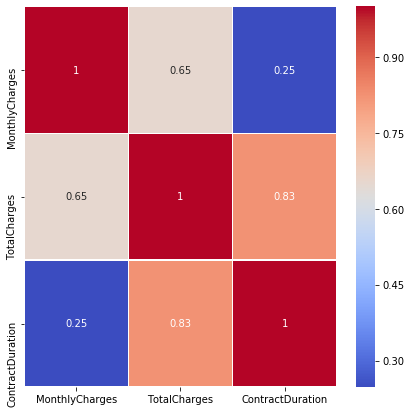

In [32]:
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(num_features_data.corr(),cmap='coolwarm',annot=True, linewidths=.5)
plt.show()

## 4.5. Оценка корреляции количественных признаков.Вывод.

Не обнаружено сильных (более 90%) корреляций количественых признаков.

# Шаг 4. Исследовательский анализ данных. Выводы.

- количество клиентов с действующим контрактом составляет около 2/3 от общего числа
- наблюдается значительный перевес, по количеству прекращенных контрактов, в группе клиентов подключенных к интернету по оптоволокну. Они более чем в 3 раза чаще разрывали контракт, чем клиенты подключенные по DSL
- значимой разницы в количестве прекращенных контрактов, между группами клиентов с одной линией телефонии и несколькими, не обнаружено (около 12% в обеих группах)
- у численных признаков MonthlyCharges и TotalCharges аномальных выбросов не обнаружено
- не обнаружено сильных (более 90%) корреляций количественных признаков

# <font color="blue"> Шаг 5. Построение модели.

## 5.1. Создание выборок (обучающая, валидационная и тестовая) и переменных

Создадим, из единого датасета, три выборки: обучающую , валидационную и тестовую. Соотношение, соответственно, 3:1:1

In [33]:
data_test, data_train_valid = train_test_split(data, test_size=0.8, random_state=12345)
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=12345)

Создаем переменные для признаков и целевого признака для каждой из 3-х выборок

In [34]:
features_test = data_test.drop(['ContractStatus'], axis=1)
target_test = data_test['ContractStatus']
features_train = data_train.drop(['ContractStatus'], axis=1)
target_train = data_train['ContractStatus']
features_valid = data_valid.drop(['ContractStatus'], axis=1)
target_valid = data_valid['ContractStatus']

Проверяем размерность выборок

In [35]:
print("Обучающая выборка:", data_train.shape)
print("Валидационная выборка:", data_valid.shape)
print("Тестовая выборка:", data_test.shape)

Обучающая выборка: (4226, 30)
Валидационная выборка: (1409, 30)
Тестовая выборка: (1408, 30)


## 5.1. Создание выборок (обучающая, валидационная и тестовая) и переменных. Вывод.

- разбиением единого датасета созданы три независимые выборки: обучающая, валидационная и тестовая (соотношение, соответственно, 3:1:1)
- размерность выборок:
    - обучающая: 4 226 х 30
    - валидационная: 1 409 х 30
    - тестовая: 1 408 х 30
- на базе обучающей выборки проведена оценка коррелиции признаков, вследствии чего были удалены из обучающей выборки признаки: 'OnlineSecurity_No data','OnlineBackup_No data','DeviceProtection_No data','TechSupport_No data','StreamingTV_No data', 'StreamingMovies_No data', как сильно коррелирующие с признаком 'InternetService_No data'
- созданы переменные для признаков и целевого признака, для каждой из получившихся выборок

## 5.2. Анализ дисбаланса классов

Оценим дисбаланс классов целевого признака ContractStatus

,quantity,%
ContractStatus,,
0,1869,26.536987
1,5174,73.463013


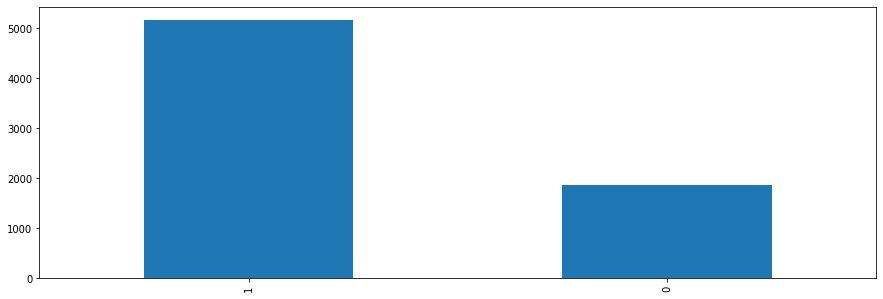

In [36]:
imbalance = data.groupby('ContractStatus').agg({'ContractStatus':'count'})
imbalance.rename(columns=lambda x: x.replace('ContractStatus', 'quantity'), inplace=True)
imbalance['%']=(imbalance['quantity']/sum(imbalance['quantity'])) * 100
display(imbalance)
data['ContractStatus'].value_counts().plot(kind='bar', figsize=(15,5))

## 5.2. Анализ дисбаланса классов. Вывод.

- наблюдается некритичный дисбаланс классов. Не будем корректировать дисбаланс, пока не убедимся в неудовлетворительном качестве модели.

## 5.3. Обучение модели

Для обучения применим алгоритмы LogisticRegression, DecisionTreeClassifier, RandomForestClassifier и LightGBM. В качестве основной метрики определяем  AUC_ROC, в качестве дополнительной - accuracy. Для итоговой проверки на тестовой выборке применим алгоритм с оптимальными гиперпараметрами.

### 5.3.1. Алгоритм `LogisticRegression`

Полнота= 0.896817743490839
Точность (accuracy)= 0.8076650106458482
Точность (precision)= 0.850091407678245
F1 = 0.8728296574378227
AUC-ROC =  0.8515932020613639


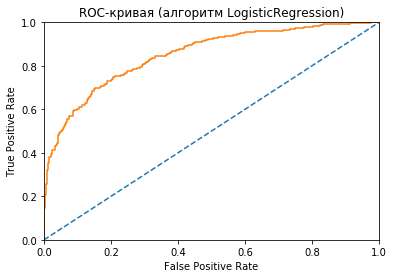

In [37]:
model_lr = LogisticRegression(random_state=12345, solver='liblinear')
model_lr.fit(features_train, target_train)
predicted_valid = model_lr.predict(features_valid)

# Расчет полноты и точности
accuracy = accuracy_score(target_valid, predicted_valid)
precision = precision_score(target_valid, predicted_valid)
recall = recall_score(target_valid, predicted_valid)

print("Полнота=", recall)
print("Точность (accuracy)=", accuracy)
print("Точность (precision)=", precision)

# Расчет F1 меры
print("F1 =",f1_score(target_valid, predicted_valid))

probabilities_valid = model_lr.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print("AUC-ROC = ", auc_roc)
# Строим ROC- кривую
plt.figure()
# Строим ROC-кривую случайной модели
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая (алгоритм LogisticRegression)')
plt.show()

### 5.3.2. Алгоритм `DecisionTreeClassifier`

In [38]:
# Цикл для перебора max_depth 
for depth in range(1, 100, 9):
    #  Создаем модель, указав max_depth=depth 
    model_dtc = DecisionTreeClassifier(random_state=12345, max_depth=depth)   
    # Обучаем модель
    model_dtc.fit(features_train, target_train)
    print("max_depth =", depth, ": ", end='')
    
    # Вычисляем предсказания на валидационной выборке
    predictions_valid_dtc = model_dtc.predict(features_valid)
    # Расчет точности, полноты и F1 меры
    print("recall =",recall_score(target_valid, predictions_valid_dtc), ": ", end='')
    print("precision =",precision_score(target_valid, predictions_valid_dtc), ": ", end='')
    print("accuracy =", accuracy_score(target_valid, predictions_valid_dtc), ": ", end='')
    print("F1 =",f1_score(target_valid, predictions_valid_dtc), ": ", end='')
    probabilities_valid = model_dtc.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print("AUC-ROC = ", auc_roc)

max_depth = 1 : recall = 0.8466730954676953 : precision = 0.8018264840182648 : accuracy = 0.7331440738112136 : F1 = 0.823639774859287 : AUC-ROC =  0.631669881067181
max_depth = 10 : recall = 0.875602700096432 : precision = 0.862298195631529 : accuracy = 0.8055358410220014 : F1 = 0.8688995215311006 : AUC-ROC =  0.8181465870324862
max_depth = 19 : recall = 0.8283510125361621 : precision = 0.8538767395626242 : accuracy = 0.7693399574166075 : F1 = 0.8409202153695546 : AUC-ROC =  0.731759573210564
max_depth = 28 : recall = 0.8379942140790743 : precision = 0.8586956521739131 : accuracy = 0.7792760823278921 : F1 = 0.8482186432406051 : AUC-ROC =  0.7274654970396408
max_depth = 37 : recall = 0.8379942140790743 : precision = 0.8586956521739131 : accuracy = 0.7792760823278921 : F1 = 0.8482186432406051 : AUC-ROC =  0.7274654970396408
max_depth = 46 : recall = 0.8379942140790743 : precision = 0.8586956521739131 : accuracy = 0.7792760823278921 : F1 = 0.8482186432406051 : AUC-ROC =  0.727465497039640

### 5.3.3. Алгоритм `RandomForestClassifier`

In [39]:
estim_score  = pd.DataFrame(columns=['estimators', 'max_depth', 'recall','precision', 'accuracy', 'F1', 'AUC_ROC'])
for estim in range(1, 100,2):
    for depth_rfc in range(1,20,2):
        model_rfc = RandomForestClassifier(random_state=12345, n_estimators= estim, max_depth = depth_rfc)
        # Обучаем модель
        model_rfc.fit(features_train, target_train)
        # Вычисляем предсказания на валидационной выборке
        predictions_valid_rfc = model_rfc.predict(features_valid) 
        # Расчет точности, полноты и F1 меры
        predictions_valid_rfc = model_rfc.predict(features_valid) 
        recall = recall_score(target_valid, predictions_valid_rfc)
        precision = precision_score(target_valid, predictions_valid_rfc)
        accuracy = accuracy_score(target_valid, predictions_valid_rfc)
        f1_rfc = f1_score(target_valid, predictions_valid_rfc)
        probabilities_valid = model_rfc.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_rfc = roc_auc_score(target_valid, probabilities_one_valid)
        estim_score= estim_score.append({'estimators': estim, 'max_depth': depth_rfc, 'recall': recall,
                                         'precision': precision, 'accuracy': accuracy, 'F1': f1_rfc ,
                                         'AUC_ROC':auc_roc_rfc}, ignore_index=True)

# Ищем строки с максимальным значением AUC_ROC
print("Лучшие результаты обученных моделей")
display(estim_score.sort_values(by = 'AUC_ROC', ascending = False).head())

Лучшие результаты обученных моделей


,estimators,max_depth,recall,precision,accuracy,F1,AUC_ROC
194,39.0,9.0,0.935391,0.844212,0.825408,0.887466,0.863362
184,37.0,9.0,0.933462,0.845415,0.825408,0.887259,0.863045
364,73.0,9.0,0.932498,0.840870,0.820440,0.884316,0.862698
174,35.0,9.0,0.932498,0.843805,0.823279,0.885937,0.862645
374,75.0,9.0,0.931533,0.840000,0.819021,0.883402,0.862621


Посмотрим какие именно признаки наиболее важны для модели

In [40]:
feature_imp = pd.DataFrame(model_rfc.feature_importances_, index=features_train.columns, columns=["importance"])
feature_imp = feature_imp.sort_values(by = 'importance',ascending = False).reset_index()
feature_imp.rename(columns={'index':'feature'}, inplace=True)
feature_imp

,feature,importance
0,ContractDuration,0.213471
1,TotalCharges,0.190819
2,MonthlyCharges,0.154369
3,InternetService_Fiber optic,0.041905
4,PaymentMethod_Electronic check,0.033205
5,Type_Two year,0.030644
6,gender_Male,0.025877
7,OnlineSecurity_Yes,0.025122
8,PaperlessBilling_Yes,0.023473
9,TechSupport_Yes,0.023022


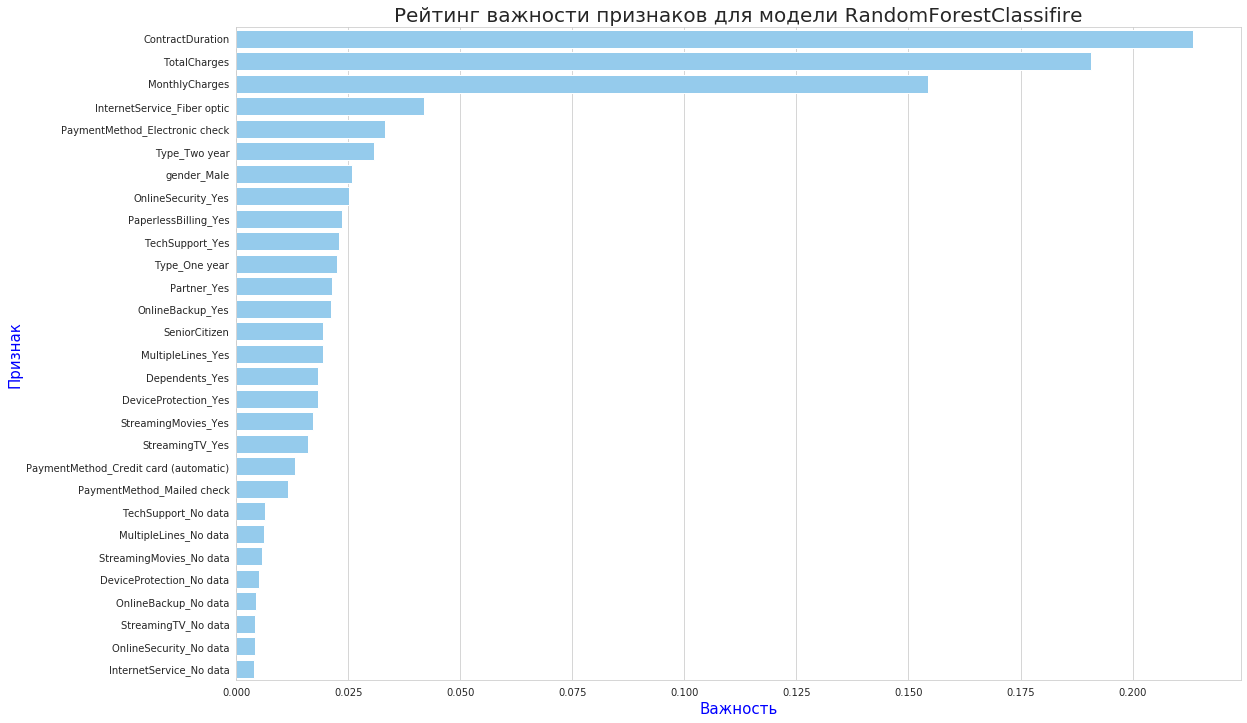

In [41]:
plt.figure(figsize=(18, 12))
with sns.axes_style('whitegrid'):
    sns.barplot(feature_imp['importance'], feature_imp['feature'], color = 'lightskyblue')
    plt.xlabel('Важность', fontsize = 15, color = 'blue')
    plt.ylabel('Признак', fontsize = 15, color = 'blue')
    plt.title('Рейтинг важности признаков для модели RandomForestClassifire', fontsize = 20)
    plt.xticks(rotation= 0)

### 5.3.4. Алгоритм `LightGBM`

In [42]:
%%time

result = pd.DataFrame(columns=['max_depth','n_estimators', 'recall', 'precision', 'accuracy', 'F1', 'AUC_ROC'])
print("Идет обучение модели на базе алгоритма LightGBM ...")

i=0
for max_depth in range(1,52,5):
    for max_estimators in range(1,202,25):
        model_LGBM = LGBMClassifier(max_depth = max_depth, n_estimators= max_estimators, random_state=12345)
        model_LGBM.fit(features_train, target_train)
        predictions_valid_LGBM = model_LGBM.predict(features_valid)
        recall = recall_score(target_valid, predictions_valid_LGBM)
        precision = precision_score(target_valid, predictions_valid_LGBM)
        accuracy = accuracy_score(target_valid, predictions_valid_LGBM)
        f1_LGBM = f1_score(target_valid, predictions_valid_LGBM)
        probabilities_valid = model_LGBM.predict_proba(features_valid)
        probabilities_one_valid = probabilities_valid[:, 1]
        auc_roc_LGBM = roc_auc_score(target_valid, probabilities_one_valid)
        
        result.loc[i] = [max_depth, int(max_estimators), recall, precision, accuracy, f1_LGBM, auc_roc_LGBM]
        print(result.loc[i])
        i+=1

Идет обучение модели на базе алгоритма LightGBM ...
max_depth       1.000000
n_estimators    1.000000
recall          1.000000
precision       0.735983
accuracy        0.735983
F1              0.847915
AUC_ROC         0.631670
Name: 0, dtype: float64
max_depth        1.000000
n_estimators    26.000000
recall           0.972035
precision        0.775385
accuracy         0.772179
F1               0.862644
AUC_ROC          0.834090
Name: 1, dtype: float64
max_depth        1.000000
n_estimators    51.000000
recall           0.960463
precision        0.795527
accuracy         0.789212
F1               0.870249
AUC_ROC          0.848385
Name: 2, dtype: float64
max_depth        1.000000
n_estimators    76.000000
recall           0.949855
precision        0.815397
accuracy         0.804826
F1               0.877506
AUC_ROC          0.852910
Name: 3, dtype: float64
max_depth         1.000000
n_estimators    101.000000
recall            0.944069
precision         0.816514
accuracy          0.802

In [43]:
print('Результаты обучения алгоритмом LightGBM', end = '\n')
result.sort_values('AUC_ROC', ascending = False)

Результаты обучения алгоритмом LightGBM


,max_depth,n_estimators,recall,precision,accuracy,F1,AUC_ROC
34,16.0,176.0,0.931533,0.882998,0.858765,0.906617,0.899641
35,16.0,201.0,0.933462,0.883212,0.860185,0.907642,0.898798
33,16.0,151.0,0.930569,0.878071,0.853797,0.903558,0.898700
32,16.0,126.0,0.936355,0.877145,0.856636,0.905784,0.897468
31,16.0,101.0,0.937319,0.874887,0.855216,0.905028,0.895006
...,...,...,...,...,...,...,...
36,21.0,1.0,1.000000,0.735983,0.735983,0.847915,0.832908
27,16.0,1.0,1.000000,0.735983,0.735983,0.847915,0.832908
72,41.0,1.0,1.000000,0.735983,0.735983,0.847915,0.832908
81,46.0,1.0,1.000000,0.735983,0.735983,0.847915,0.832908


Смотрим рейтинг важности признаков

In [44]:
feature_imp = pd.DataFrame(model_LGBM.feature_importances_, index=features_train.columns, columns=["importance"])
feature_imp = feature_imp.sort_values(by = 'importance',ascending = False).reset_index()
feature_imp.rename(columns={'index':'feature'}, inplace=True)
feature_imp

,feature,importance
0,ContractDuration,1671
1,MonthlyCharges,1332
2,TotalCharges,1213
3,gender_Male,210
4,Partner_Yes,146
5,OnlineBackup_Yes,130
6,Dependents_Yes,127
7,TechSupport_Yes,114
8,PaymentMethod_Electronic check,109
9,DeviceProtection_Yes,108


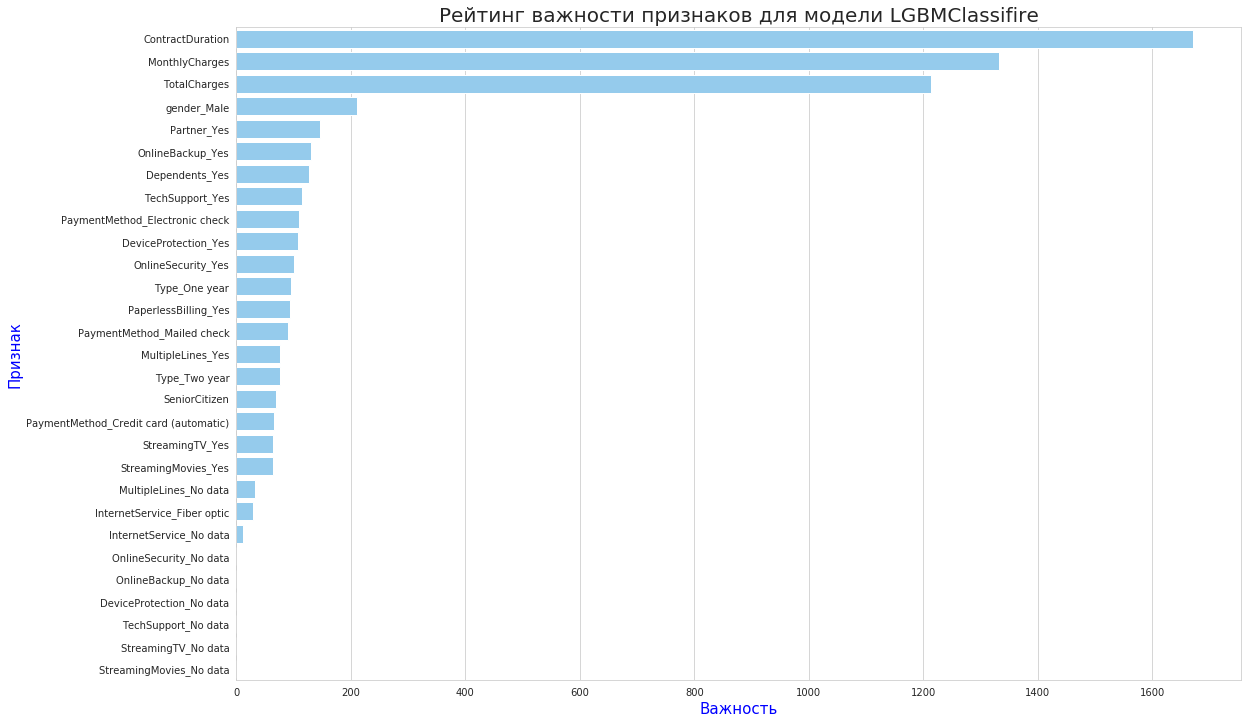

In [45]:
plt.figure(figsize=(18, 12))
with sns.axes_style('whitegrid'):
    sns.barplot(feature_imp['importance'], feature_imp['feature'], color = 'lightskyblue')
    plt.xlabel('Важность', fontsize = 15, color = 'blue')
    plt.ylabel('Признак', fontsize = 15, color = 'blue')
    plt.title('Рейтинг важности признаков для модели LGBMClassifire', fontsize = 20)
    plt.xticks(rotation= 0)

## 5.3. Обучение модели. Вывод.

- для обучения были использованы алгоритмы: `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier` и `LightGBM`.
- в качестве метрик определены: `AUC_ROC` и `accuracy`.
- по результатам обучения модели достигнуты следующие показатели:
    - алгоритм `LogisticRegression`:
        - полнота (recall): 0.896817743490839
        - точность (accuracy): 0.8076650106458482
        - точность (precision): 0.850091407678245
        - F1: 0.8728296574378227
        - AUC-ROC:  0.8515932020613639
    - алгоритм `DecisionTreeClassifier`:
        - наилучший результат достигнут при максимальной глубине деревьев (max-depth) = 10, а именно:
            - полнота (recall): 0.875602700096432
            - точность (accuracy): 0.8055358410220014
            - точность (precision): 0.862298195631529
            - F1: 0.8688995215311006
            - AUC-ROC: 0.8181465870324862
    - алгоритм `RandomForestClassifier`:
        - наилучший результат достигнут при максимальной глубине деревьев (max-depth) = 9 и количеству estimators = 39, а именно:
            - полнота (recall): 0.935391
            - точность (accuracy): 0.825408
            - точность (precision): 0.844212
            - F1: 0.887466
            - AUC-ROC: 0.863362
        - наиболее важными, для обучения модели, признаками являются: `ContractDuration`, `TotalCharges`, `MonthlyCharges`
    - алгоритм `LightGBM`:
        - наилучший результат достигнут при максимальной глубине деревьев (max_depth) = 16 и количеству estimators = 176, а именно:
        max_depth	max_estimators	recall	precision	accuracy	F1	AUC_ROC
34	16.0	176.0	0.931533	0.882998	0.858765	0.906617	0.899641
            - полнота (recall): 0.931533
            - точность (accuracy): 0.858765
            - точность (precision): 0.882998
            - F1: 0.906617	
            - AUC-ROC: 0.899641
        - наиболее важными, для обучения модели, признаками являются: `ContractDuration`, `TotalCharges`, `MonthlyCharges`
- в качестве модели для тестирования выбрана модель на базе алгоритма `LightGBM`, с гиперпараметрами `max_depth`= 16 и `estimators`= 176

# Шаг 5. Построение модели. Выводы.

- созданы три независимые выборки: обучающая, валидационная и тестовая (соотношение, соответственно, 3:1:1)
- размерность выборок:
    - обучающая: 4 226 х 30
    - валидационная: 1 409 х 30
    - тестовая: 1 408 х 30
- созданы переменные для признаков и целевого признака, для каждой из 3-х выборок
- наблюдается некритичный дисбаланс классов. Принято решение не корректировать дисбаланс, так как получившаяся модель показывает вполне достойные результаты
- для обучения использованы алгоритмы: `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier` и `LightGBM`
- метриками качества определены: `AUC_ROC`(основная) и 'accuracy'(дополнительная)
- в качестве модели для тестирования выбрана модель на базе алгоритма `LightGBM` с гиперпараметрами `max-depth`= 16 и `estimators`= 176, показавшая наилучшие показатели:
    - полнота (recall): 0.931533
    - точность (accuracy): 0.858765
    - точность (precision): 0.882998
    - F1: 0.906617	
    - AUC-ROC: 0.899641

# <font color="blue"> Шаг 6. Тестирование модели.

Тестируем модель на тестовой выборке.

Точность (accuracy)= 0.8338068181818182
Точность (precision)= 0.8570151921358355
Полнота= 0.9283639883833494
F1 = 0.891263940520446
AUC-ROC =  0.8755056469828978


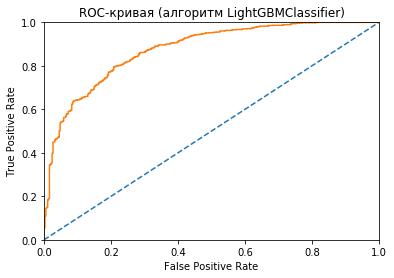

In [46]:
model = LGBMClassifier(max_depth = 16, n_estimators= 176, random_state=12345)
# Обучение
model.fit(features_train, target_train)
test_predictions = model.predict(features_test)

# Расчет полноты и точности
accuracy = accuracy_score(target_test, test_predictions)
precision = precision_score(target_test, test_predictions)
recall = recall_score(target_test, test_predictions)
print('Точность (accuracy)=', accuracy)
print("Точность (precision)=", precision)
print("Полнота=", recall)

# Расчет F1 меры
print("F1 =",f1_score(target_test, test_predictions))
# Расчет AUC-ROC
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print("AUC-ROC = ", auc_roc)
#Строим ROC- кривую
plt.figure()
# Строим ROC-кривую случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая (алгоритм LightGBMClassifier)')
plt.show()

# Шаг 6. Тестирование модели. Выводы.

В результате проверки модели, на базе алгоритма `LightGBM` (гиперпараметры: max_depth =  16 и n_estimators = 176), на тестовой выборке, получены следующие результаты:

- полнота (recall): 0.9283639883833494
- точность (accuracy): 0.8338068181818182
- точность (precision): 0.8570151921358355
- F1: 0.891263940520446
- AUC-ROC: 0.8755056469828978


# <font color="blue"> Шаг 7. Общий вывод.
    
#### Задачи

В ходе проекта необходимо было решить следующие задачи:

- построить модель с максимальным значением `AUC-ROC`, c целью предсказания оттока клиентов
- проверить AUC-ROC на тестовой выборке
- в качестве дополнительной метрики максимизировать accuracy

#### Этапы решения
    
В ходе решения задач были выполнены следующие этапы:
    
- загрузка исходных данных
- подготовка данных:
        - преобразование типов данных
        - проверка на дубликаты
        - объединение датасетов
        - замена пропусков
- создание тренинговой, валидационной и тестовой выборок
- обучение модели алгоритмами: `LogisticRegression`, `DecisionTreeClassifier`, `RandomForestClassifier`, `LightGBM`
- подбор оптимальных гиперпараметров
- тестирование обученной модели на тестовой выборке
    
#### Результат
    
Наилучшие результаты показала модель на основе алгоритма `LightGBM` (гиперпараметры: max_depth =  11 и n_estimators = 201) с результатом:
    
- точность (accuracy): 0.8338068181818182
- AUC-ROC: 0.8755056469828978
    
Полученные результаты позволяют говорить о достаточной эффективности модели.

#### Благодарю за внимание!